In [43]:
import numpy as np

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

import deepxde as dde
dde.backend.set_default_backend("tensorflow")
import tensorflow as tf

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [44]:
t_max = 5

rpho = 100
mu = 1e-6

A = 1
x_min, x_max = 0, 1
y_min, y_max = 0, 1

step = 0.05
step_t = 0.05

t_points = int(t_max / step_t)
x_points = int((x_max - x_min) / step)
y_points = int((y_max - y_min) / step)

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_min, x_max, x_points)
y = np.linspace(y_min, y_max, y_points)
t = np.linspace(0, t_max, t_points)
x, y, t = np.meshgrid(x, y, t)
xyt_domain = np.hstack((x.flatten()[:, None], y.flatten()[:, None], t.flatten()[:, None]))

space_domain = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
time_domain = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(space_domain, time_domain)

In [45]:
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is y-coordinate
           x[:,2] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x, y, t) the speed for x component
            y[:,1] is v(x, y, t) the speed for y component
            y[:,2] is p(x, y, t) the pressure
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """
    u, v, p = y[:,0], y[:, 1], y[:, 2]
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    d2u_x2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2v_x2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2u_y2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2v_y2 = dde.grad.hessian(y, x, component=1, i=1, j=1)

    f_u = du_t + u * du_x + v * du_y + 1 / rpho * dp_x - mu * (d2u_x2 + d2u_y2)
    f_v = dv_t + u * dv_x + v * dv_y + 1 / rpho * dp_y - mu * (d2v_x2 + d2v_y2)
    f_continuity = du_x + dv_y

    return [f_u, f_v, f_continuity]

In [46]:

# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.DirichletBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=0)
bc_v_0 = dde.icbc.DirichletBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=1)
# bc_p_0 = dde.icbc.DirichletBC(domain, 0, lambda _, on_boundary: on_boundary)

# Initial conditions
def init_cond_u(x):
    return np.array([A] * len(x))

def init_cond_v(x):
    return np.array([A] * len(x))


ic_u = dde.icbc.IC(domain, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(domain, init_cond_v, lambda _, on_initial: on_initial, component=1)


In [47]:
data = dde.data.TimePDE(domain, pde, [bc_u_0, bc_u_0, ic_u, ic_v],
                         num_domain=x_points * y_points,
                         num_boundary=2*(x_points+y_points),
                         num_initial=x_points*y_points,
                         train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([3] + [16] * 4 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [48]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=100, display_every=10)

Compiling model...
'compile' took 0.003244 s

Training model...

0         [1.66e-01, 3.69e-02, 2.92e-02, 5.50e-01, 5.50e-01, 1.76e+00, 9.96e-01]    [1.66e-01, 3.69e-02, 2.92e-02, 5.50e-01, 5.50e-01, 1.76e+00, 9.96e-01]    []  
10        [2.88e-02, 7.44e-03, 5.19e-02, 2.74e-02, 2.74e-02, 9.85e-01, 7.99e-01]    [2.88e-02, 7.44e-03, 5.19e-02, 2.74e-02, 2.74e-02, 9.85e-01, 7.99e-01]    []  
20        [5.69e-04, 8.51e-03, 6.75e-02, 4.45e-02, 4.45e-02, 5.67e-01, 5.10e-01]    [5.69e-04, 8.51e-03, 6.75e-02, 4.45e-02, 4.45e-02, 5.67e-01, 5.10e-01]    []  
30        [1.68e-03, 2.95e-02, 6.16e-02, 6.55e-02, 6.55e-02, 3.77e-01, 2.38e-01]    [1.68e-03, 2.95e-02, 6.16e-02, 6.55e-02, 6.55e-02, 3.77e-01, 2.38e-01]    []  
40        [7.79e-03, 3.32e-02, 3.61e-02, 4.18e-02, 4.18e-02, 2.80e-01, 9.52e-02]    [7.79e-03, 3.32e-02, 3.61e-02, 4.18e-02, 4.18e-02, 2.80e-01, 9.52e-02]    []  
50        [1.93e-02, 2.32e-02, 1.45e-02, 4.98e-02, 4.98e-02, 1.85e-01, 4.47e-02]    [1.93e-02, 2.32e-02, 1.45e-02, 4.98e

(<deepxde.model.LossHistory at 0x782bbbf07790>,
 <deepxde.model.TrainState at 0x782bbbef5220>)

In [49]:
# dde.optimizers.config.set_LBFGS_options(
#     maxcor=50,
#     ftol=1.0 * np.finfo(float).eps,
#     gtol=1e-08,
#     maxiter=10000,
#     maxfun=10000,
#     maxls=50,
# )
# model.compile("L-BFGS")
# model.train()

In [50]:
prediction = model.predict(xyt_domain, operator=None)

u_predict = griddata(xyt_domain, prediction[:, 0], (x, y, t), method="linear")
v_predict = griddata(xyt_domain, prediction[:, 1], (x, y, t), method="linear")
p_predict = griddata(xyt_domain, prediction[:, 2], (x, y, t), method="linear")



In [51]:

# fig, ax = plt.subplots(4)

# ax[0].set_ylabel("vr part")
# vuv_quiver = ax[0].quiver(
#     np.arange(u_predict.shape[0]),
#     np.arange(u_predict.shape[1]),
#     u_predict[:,:,0].T, 
#     v_predict[:,:,0].T,
#     angles='xy', scale_units='xy', scale=1
# )

# ax[1].set_ylabel("p part")
# p_plot = ax[1].imshow(
#     p_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[2].set_ylabel("u part")
# u_plot = ax[2].imshow(
#     v_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[3].set_ylabel("v part")
# v_plot = ax[3].imshow(
#     u_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# multiplier = 15
# def animate(t_curr):
#     ax[0].set_title(f"Results t={t_curr}")
#     vuv_quiver.set_UVC(multiplier * u_predict[:,:,t_curr].T, multiplier * v_predict[:,:,t_curr].T)
#     p_plot.set_array(p_predict[:,:,t_curr].T)
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return vuv_quiver, p_plot, u_plot, v_plot

# t_curr = 0
# ani = FuncAnimation(fig, animate, frames=len(u_predict[0,0,:]), interval=100, blit=True)

# ani.save("animation.gif", writer="imagemagick", fps=10)

# plt.show()

In [52]:
# fig_u, ax_u = plt.subplots(1)

# ax_u.set_ylabel("u part")
# u_plot = ax_u.imshow(
#     v_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# fig_v, ax_v = plt.subplots(1)
# ax_v.set_ylabel("v part")
# v_plot = ax_v.imshow(
#     u_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# fig_v.colorbar(ax_v)

# multiplier = 15
# def animate_u(t_curr):
#     ax_u.set_title(f"Results t={t_curr}")
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     return u_plot,

# def animate_v(t_curr):
#     ax_v.set_title(f"Results t={t_curr}")
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return v_plot,

# ani_u = FuncAnimation(fig_u, animate_u, frames=len(u_predict[0,0,:]), blit=True)
# ani_v = FuncAnimation(fig_v, animate_v, frames=len(v_predict[0,0,:]), blit=True)

# ani_u.save("animation_u.gif", writer="imagemagick", fps=10)
# ani_v.save("animation_v.gif", writer="imagemagick", fps=10)

# plt.show()

0.5450445413589478
0.8426495790481567


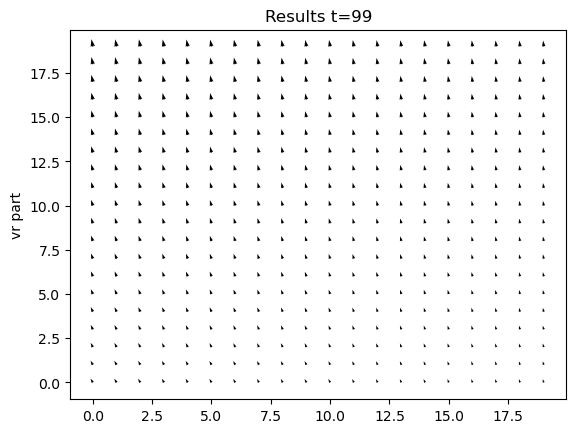

In [53]:
print(np.min(u_predict[:,:,0].T))
print(np.max(u_predict[:,:,0].T))

fig, ax = plt.subplots(1)

ax.set_ylabel("vr part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,0].T, 
    v_predict[:,:,0].T,
    angles='xy', scale_units='xy', scale=1
)

def animate(t_curr):
    ax.set_title(f"Results t={t_curr}")
    vuv_quiver.set_UVC(u_predict[:,:,t_curr].T, v_predict[:,:,t_curr].T)
    return vuv_quiver,

ani_xy = FuncAnimation(fig, animate, frames=len(v_predict[0,0,:]), blit=True)

ani_xy.save("animation_xy.gif", writer="imagemagick", fps=5)

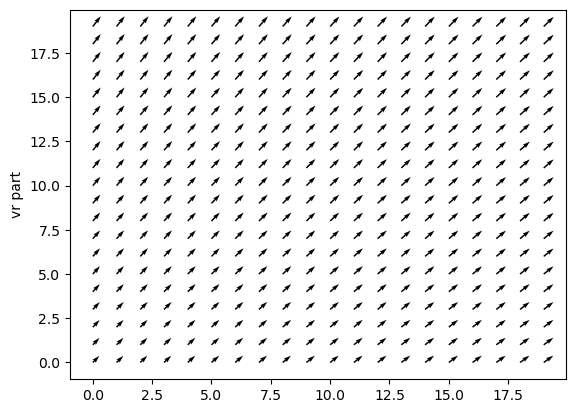

In [54]:
fig, ax = plt.subplots(1)
frame = 0
ax.set_ylabel("vr part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,frame].T, 
    v_predict[:,:,frame].T,
    angles='xy', scale_units='xy', scale=2
)